In [37]:
import cv2
import json
import os
import yaml  # yaml 라이브러리 임포트
import numpy as np
from google import genai
from google.genai import types
from ultralytics import YOLO
from IPython.display import display
from PIL import Image
from dotenv import load_dotenv

# 1. 환경 변수 로드
load_dotenv()
client = genai.Client(api_key=os.environ.get("GEMINI_API_KEY"))

YAML 파일에서 시스템 프롬프트 불러오기

In [38]:
yaml_path = "src/prompt.yaml"

try:
    with open(yaml_path, "r", encoding="utf-8") as f:
        config_data = yaml.safe_load(f)
        # yaml 파일의 'template' 키에 해당하는 내용을 가져옵니다.
        SYSTEM_INSTRUCTION = config_data["template"]
        print(f"'{yaml_path}'에서 프롬프트를 성공적으로 로드했습니다.")
except FileNotFoundError:
    print(f"'{yaml_path}' 파일을 찾을 수 없습니다. 기본 프롬프트를 사용합니다.")
    SYSTEM_INSTRUCTION = "당신은 AI 어시스턴트입니다."

'src/prompt.yaml'에서 프롬프트를 성공적으로 로드했습니다.


이미지 처리 및 YOLO Detection

In [39]:
img_path = "src/dogman.jpg" # 다운로드 받은 이미지 파일명

if not os.path.exists(img_path):
    print("이미지 파일이 없습니다. 경로를 확인해주세요.")
    # 테스트용 빈 캔버스
    frame = np.zeros((900, 1600, 3), dtype=np.uint8)
else:
    frame = cv2.imread(img_path)

frame = cv2.resize(frame, (1600, 900))

In [40]:
# YOLO 실행
model = YOLO("yolo11n.pt")
results = model(source=frame, conf=0.3, verbose=False)

In [41]:
# 정보 추출
info = {}
annot_frame = frame.copy()

# 감지된 목록 확인용 리스트
detected_labels = []

for res in results:
    for b in res.boxes:
        cls = int(b.cls[0].item())
        label = res.names.get(cls, str(cls))
        conf = round(b.conf[0].item(), 2)
        x1, y1, x2, y2 = map(int, b.xyxy[0])
        x, y, w, h = map(int, b.xywh[0])
        
        # 감지된 것 기록
        detected_labels.append(label)

        info.setdefault(label, []).append({
            "location": [x, y],
            "size": w * h,
            "bbox": [x1, y1, x2, y2],
            "confidence": conf
        })
        
        cv2.rectangle(annot_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annot_frame, f"{label} {conf}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

info_str = json.dumps(info, ensure_ascii=False, indent=2)

YOLO가 감지한 물체 목록: ['car', 'person', 'dog']


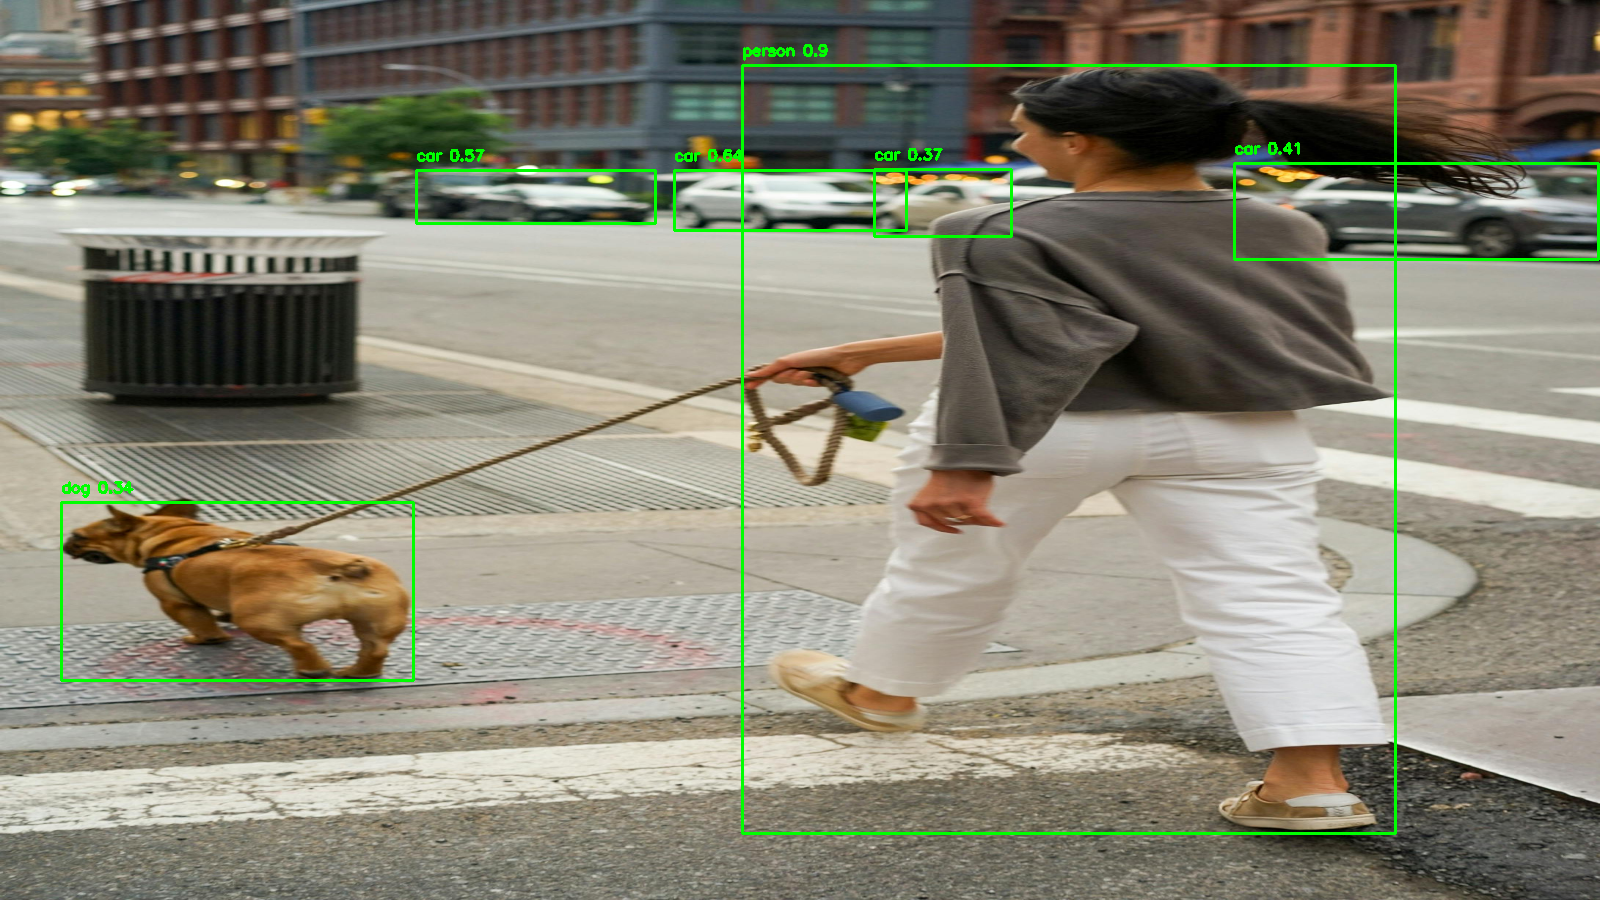

In [42]:
print(f"YOLO가 감지한 물체 목록: {list(set(detected_labels))}")
display(Image.fromarray(cv2.cvtColor(annot_frame, cv2.COLOR_BGR2RGB))) 

Gemini에게 질문하기 (로드한 프롬프트 적용)

In [43]:
def ask_gemini(question, detected_info):
    # 사용자 질문 구성
    user_content = f"""
    # 감지된 객체 정보 (JSON):
    {detected_info}

    # 질문:
    {question}
    """

    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash-lite", 
            config=types.GenerateContentConfig(
                # 여기서 YAML에서 불러온 시스템 지침을 적용합니다!
                system_instruction=SYSTEM_INSTRUCTION, 
                temperature=0.1,
            ),
            contents=user_content
        )
        return response.text
    except Exception as e:
        return f"에러 발생: {e}"

In [44]:
# 테스트 실행
print("\n[Gemini 분석 결과]")
print(f"Q: 지금 보이는 상황을 설명해줘")
print(f"A: {ask_gemini('지금 보이는 상황을 설명해줘', info_str)}")


[Gemini 분석 결과]
Q: 지금 보이는 상황을 설명해줘
A: 에러 발생: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 1.11755311s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'locat

In [45]:
# 질문 정의
question = "지금 보이는 사진에 강아지는 없어?"
answer = ask_gemini(question,info_str)

print("답변:", answer)

답변: 에러 발생: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 941.491727ms.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-

In [46]:
question = "지금 보이는 사진에서 자동차들의 위치는 어디야?"
answer = ask_gemini(question,info_str)

print("답변:", answer)

답변: 에러 발생: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 834.248976ms.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'loca